# IV Index Method

This method creates an IV index. It takes the options chain and a term as inputs. From the options chain it then gets the contracts whose days to expiry are/is closest to the term. It gets the strikes closest to atm. It then weights the 4 contracts by distance to term and by distance from atm strike. The result is a series of the implied volatility index of given term.

## Imports

In [34]:
from DataHandler import DataHandler
from Statistics import Statistics, Statistics2
from Utils import Utils, ModelUtils

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from scipy import stats

In [40]:
file_path = "Data/SPY_Options_log.txt"
# file_path = "Data/SampleConsolodatedTradeBarLog.txt"
dh = DataHandler()

df = dh.parse_file(file_path=file_path)
df = dh.get_basic_data(df)
df

c:\Users\mbeckhusen\Documents\VolaSurfer\Utils.py:9: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
c:\Users\mbeckhusen\Documents\VolaSurfer\Utils.py:10: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
c:\Users\mbeckhusen\Documents\VolaSurfer\Utils.py:142: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S/K) + (r + 0.5 * np.power(sigma, 2)) * T) / sigma *np.sqrt(T)
c:\Users\mbeckhusen\Documents\VolaSurfer\Utils.py:143: RuntimeWarning: invalid value encountered in sqrt
  vg = S * norm.pdf(d1, 0.0, 1.0) * np.sqrt(T)


,timestamp,ticker_option,maturity,strike,option_type,bid_open,bid_high,bid_low,bid_close,ask_open,...,close,volume,bid_mid,ask_mid,mid_price,T,days_to_expiry,implied_volatility,log_strike,vega
0,2023-01-04 06:30:00,SPY,2023-01-20,364.0,Call,19.79,24.36,17.02,18.99,24.79,...,380.82,66519705.0,19.390,22.485,20.9375,0.043094,15.729167,0.314915,0.954827,31.521391
1,2023-01-04 06:30:00,SPY,2023-01-20,365.0,Call,18.93,23.47,16.11,18.17,23.93,...,380.82,66519705.0,18.550,21.635,20.0925,0.043094,15.729167,0.310893,0.957571,31.522844
2,2023-01-04 06:30:00,SPY,2023-01-20,366.0,Call,18.08,22.60,15.36,17.37,23.08,...,380.82,66519705.0,17.725,20.765,19.2450,0.043094,15.729167,0.306440,0.960307,31.524227
3,2023-01-04 06:30:00,SPY,2023-01-20,367.0,Call,18.19,21.74,14.76,16.58,23.19,...,380.82,66519705.0,17.385,20.435,18.9100,0.043094,15.729167,0.321574,0.963035,31.526919
4,2023-01-04 06:30:00,SPY,2023-01-20,368.0,Call,17.02,20.88,14.05,15.81,22.02,...,380.82,66519705.0,16.415,19.450,17.9325,0.043094,15.729167,0.311165,0.965756,31.527759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45020,2023-11-06 06:30:00,SPY,2023-11-17,418.0,Put,1.31,1.31,0.65,0.71,1.32,...,434.69,88515231.0,1.010,1.020,1.0150,0.029395,10.729167,NaN,0.960848,NaN
45021,2023-11-06 06:30:00,SPY,2023-11-17,419.0,Put,1.44,1.44,0.70,0.77,1.45,...,434.69,88515231.0,1.105,1.115,1.1100,0.029395,10.729167,NaN,0.963238,NaN
45022,2023-11-06 06:30:00,SPY,2023-12-15,418.0,Call,18.66,23.03,18.66,20.86,19.52,...,434.69,88515231.0,19.760,21.350,20.5550,0.106107,38.729167,0.138812,0.960848,56.168015
45023,2023-11-06 06:30:00,SPY,2023-12-15,419.0,Call,16.87,22.21,16.87,20.01,18.39,...,434.69,88515231.0,18.440,20.355,19.3975,0.106107,38.729167,0.129109,0.963238,56.158085


In [38]:
df_call = df[df['option_type']=='Call']

In [39]:
df_call.implied_volatility

0       0.157229
1       0.150693
4       0.140059
5       0.136812
8       0.126776
          ...   
8101    0.104803
8104    0.095704
8105    0.096152
8108    0.088922
8109    0.090188
Name: implied_volatility, Length: 4056, dtype: float64

In [36]:
df_put = df[df['option_type']=='Put']

In [37]:
df_put.implied_volatility

2       0.201736
3       0.280194
6       0.163293
7       0.206028
10      0.159224
          ...   
8103    0.117111
8106    0.081112
8107    0.113030
8110    0.089113
8111    0.114819
Name: implied_volatility, Length: 4056, dtype: float64

In [96]:
df_put.vega

2       11.912978
3       11.912892
6       22.009819
7       22.010457
10      30.198178
          ...    
8103    29.789644
8106    34.915430
8107    35.157048
8110    43.937307
8111    44.629303
Name: vega, Length: 4056, dtype: float64

In [14]:
def iv_index(df, maturity: int):

    if "implied_volatility" and "days_to_expiry" not in df.columns:
        print("implied volatility is missing!")
    
    print(df['implied_volatility'].head())
    print(df['days_to_expiry'].min())    
    print(df['days_to_expiry'].max())    
    df_sorted_by_mat = df['days_to_expiry'] - maturity
    df_sorted_by_mat
    sorted(df_sorted_by_mat, )
    print(df_sorted_by_mat)

iv_index(df_call, 30)

0    0.314915
1    0.310893
2    0.306440
3    0.321574
4    0.311165
Name: implied_volatility, dtype: float64
-0.2708333333333333
98.72916666666667
0       -14.270833
1       -14.270833
2       -14.270833
3       -14.270833
4       -14.270833
           ...    
45009    43.729167
45018   -19.270833
45019   -19.270833
45022     8.729167
45023     8.729167
Name: days_to_expiry, Length: 22510, dtype: float64


In [97]:
df_call.vega

0       11.912973
1       11.912576
4       22.009748
5       22.010106
8       30.194794
          ...    
8101    29.782957
8104    35.005261
8105    35.124517
8108    43.932656
8109    44.368002
Name: vega, Length: 4056, dtype: float64

In [20]:
df_call.columns

Index(['timestamp', 'ticker_option', 'maturity', 'strike', 'option_type',
       'bid_open', 'bid_high', 'bid_low', 'bid_close', 'ask_open', 'ask_high',
       'ask_low', 'ask_close', 'ticker_price', 'open', 'high', 'low', 'close',
       'volume', 'bid_mid', 'ask_mid', 'mid_price', 'T', 'days_to_expiry',
       'implied_volatility', 'log_strike', 'vega'],
      dtype='object')

## Methodology

1. we defined a term, i.e. 30 days
2. we get the maturities that are closest to our term. if there is a maturity that matches our term exactly, hence "term == maturity" use only one maturity
- calculate difference between an options days to expiry and our selected term
- for each unique timestamp, return options whose maturity whose difference is closest to 0
3. out of the selected maturities, get the strike nearest to underlying close price 

1. define term and type (call, put, or average)
2. get maturities closest to term, i.e. 30 day term -> 15 day maturity and 45 day maturity
3. calculate iv index for selected maturities -> get 4 contracts with strikes nearest to current stock price, then weigh by vega 

In [ ]:
at each timestamp, filter the options whose 'days_to_expiry' is nearest to term, out of these, take two expiries.
then, calculate the strike diff in relation to stock price, here take four.

for maturity in nearest_maturity:
    my_four_strikes = get_four_atm_strike(nearest_maturity)
    for strike in my_four_strikes:
        vega_weight_iv_of_strike = strike.implied_volatility * strike.vega
        
    final_iv_value = sum(vega_weight_iv_of_strike * strike.strike_diff)/len(my_four_strikes)

## Version 1

In [98]:
def select_iv_index_options(options_df: pd.DataFrame, term: int) -> pd.DataFrame:
    """
    Select ATM options for IV index calculation based on term.
    
    Args:
        options_df: DataFrame with options data
        term: Target term in days
    
    Returns:
        DataFrame with selected ATM options for each timestamp
    """
    def get_nearest_maturity(group):
        # Calculate difference between term and days to expiry
        group['term_diff'] = abs(group['days_to_expiry'] - term)
        
        # If exact match exists, use only that maturity
        exact_match = group[group['days_to_expiry'] == term]
        if not exact_match.empty:
            return exact_match
        
        # TODO sort by min diff, this way we can select multiple maturities
        # Otherwise get maturity with smallest difference
        min_diff = group['term_diff'].min()

        #TODO return two maturities instead of one
        return group[group['term_diff'] == min_diff]
    
    def get_nearest_strikes(group):
        #TODO get 4 strikes instead of 1
        # Get the nearest strike to close price
        closest_strike = group.iloc[(group['strike'] - group['close']).abs().argsort()[:1]]
        #TODO add strike-diff-weight
        return closest_strike

    # Process data timestamp by timestamp
    selected_options = []
    
    for ts, ts_group in options_df.groupby('timestamp'):
        # Get options with nearest maturity to term
        nearest_maturity = get_nearest_maturity(ts_group)
        
        # Get ATM options for each type
        calls = nearest_maturity[nearest_maturity['option_type'] == 'Call']
        puts = nearest_maturity[nearest_maturity['option_type'] == 'Put']
        
        atm_calls = get_nearest_strikes(calls)
        atm_puts = get_nearest_strikes(puts)
        
        #TODO for each contract we need a i) time-weight and a ii) strike-diff-weight
        # Combine results
        selected_options.append(pd.concat([atm_calls, atm_puts]))
    
    return pd.concat(selected_options)

# Example usage:
def calculate_iv_index(options_df: pd.DataFrame, term: int = 30) -> pd.DataFrame:
    """
    Calculate IV index for a given term.
    
    Args:
        options_df: DataFrame with options data
        term: Term in days for IV calculation (default 30)
    
    Returns:
        DataFrame with IV index values by timestamp
    """
    # Select ATM options
    selected_options = select_iv_index_options(options_df, term)
    print("printing selcted option")
    print(selected_options)
    
    # Calculate IV index by timestamp
    iv_index = []
    
    for ts, ts_group in selected_options.groupby('timestamp'):
        calls = ts_group[ts_group['option_type'] == 'Call']
        puts = ts_group[ts_group['option_type'] == 'Put']
        
        # Should only have one call and one put per timestamp
        if not (len(calls) == 1 and len(puts) == 1):
            continue
            
        iv_index.append({
            'timestamp': ts,
            'term': term,
            f'{term}_iv': (calls.iloc[0]['implied_volatility'] + puts.iloc[0]['implied_volatility']) / 2,
            'days_to_expiry': calls.iloc[0]['days_to_expiry'],
            'strike': calls.iloc[0]['strike'],
            'underlying_price': calls.iloc[0]['close']
        })
    
    return pd.DataFrame(iv_index)

In [100]:
ivindex = calculate_iv_index(df).dropna()


nearest maturity

              timestamp ticker_option   maturity  strike option_type  \
68  2023-01-04 06:30:00           SPY 2023-02-17   364.0        Call   
69  2023-01-04 06:30:00           SPY 2023-02-17   365.0        Call   
70  2023-01-04 06:30:00           SPY 2023-02-17   366.0        Call   
71  2023-01-04 06:30:00           SPY 2023-02-17   367.0        Call   
72  2023-01-04 06:30:00           SPY 2023-02-17   368.0        Call   
..                  ...           ...        ...     ...         ...   
131 2023-01-04 06:30:00           SPY 2023-02-17   393.0         Put   
132 2023-01-04 06:30:00           SPY 2023-02-17   394.0         Put   
133 2023-01-04 06:30:00           SPY 2023-02-17   395.0         Put   
134 2023-01-04 06:30:00           SPY 2023-02-17   396.0         Put   
135 2023-01-04 06:30:00           SPY 2023-02-17   397.0         Put   

     bid_open  bid_high  bid_low  bid_close  ask_open  ...      volume  \
68      24.72     28.46    21.99      23.68

In [101]:
ivindex

,timestamp,term,30_iv,days_to_expiry,strike,underlying_price
0,2023-01-04 06:30:00,30,0.211596,43.729167,381.0,380.82
1,2023-01-05 06:30:00,30,0.202292,42.729167,384.0,383.76
2,2023-01-06 06:30:00,30,0.202905,41.729167,379.0,379.38
3,2023-01-09 06:30:00,30,0.198557,38.729167,388.0,388.08
4,2023-01-10 06:30:00,30,0.199377,37.729167,388.0,387.86
...,...,...,...,...,...,...
206,2023-10-30 06:30:00,30,0.208946,17.729167,411.0,410.68
207,2023-10-31 06:30:00,30,0.197440,16.729167,416.0,415.59
208,2023-11-01 06:30:00,30,0.155169,43.729167,418.0,418.20
209,2023-11-02 06:30:00,30,0.145965,42.729167,423.0,422.66


<Axes: >

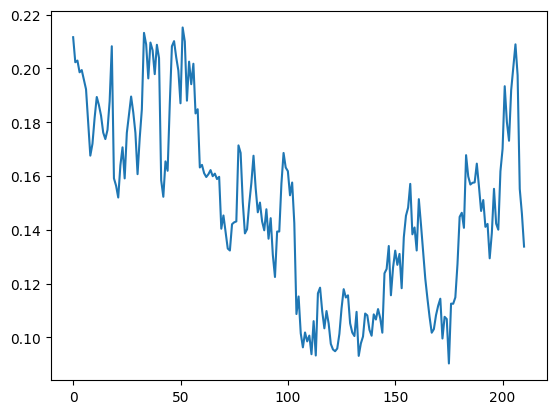

In [78]:
ivindex['30_iv'].plot()

<Axes: >

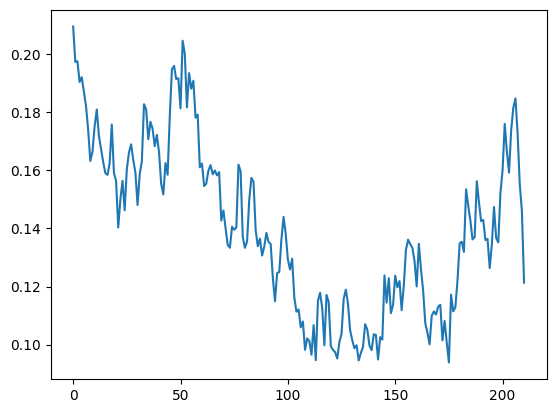

In [80]:
term = 60
ivindex60 = calculate_iv_index(df,term)
ivindex60[f'{term}_iv'].plot()

## Version 2

In [94]:
def select_atm_options(options_df: pd.DataFrame, term: int) -> pd.DataFrame:
    """
    Select ATM options for IV index calculation based on term.
    
    Args:
        options_df: DataFrame with options data
        term: Target term in days
    
    Returns:
        DataFrame with selected ATM options for each timestamp
    """
    def get_nearest_strikes(group):
        # Get the nearest strike to close price
        closest_strike = group.iloc[(group['strike'] - group['close']).abs().argsort()[:1]]
        return closest_strike

    def get_bracketing_maturities(group, term):
        # Calculate difference between term and days to expiry
        group['term_diff'] = group['days_to_expiry'] - term
        
        # If exact match exists, return it twice (as both near and far)
        exact_match = group[group['days_to_expiry'] == term]
        if not exact_match.empty:
            return exact_match, exact_match
        
        # Get nearest maturities bracketing the term
        near = group[group['term_diff'] < 0].sort_values('term_diff', ascending=False)
        far = group[group['term_diff'] > 0].sort_values('term_diff')
        
        if near.empty or far.empty:
            return None, None
            
        return near.iloc[0:1], far.iloc[0:1]

    selected_options = []
    
    for ts, ts_group in options_df.groupby('timestamp'):
        # Get options with nearest maturities
        near_group, far_group = get_bracketing_maturities(ts_group, term)
        
        if near_group is None or far_group is None:
            continue
            
        # Get ATM options for each type and maturity
        near_calls = get_nearest_strikes(near_group[near_group['option_type'] == 'Call'])
        near_puts = get_nearest_strikes(near_group[near_group['option_type'] == 'Put'])
        far_calls = get_nearest_strikes(far_group[far_group['option_type'] == 'Call'])
        far_puts = get_nearest_strikes(far_group[far_group['option_type'] == 'Put'])
        
        # Add maturity identifier
        near_calls['maturity_type'] = 'near'
        near_puts['maturity_type'] = 'near'
        far_calls['maturity_type'] = 'far'
        far_puts['maturity_type'] = 'far'
        
        # Combine results
        selected_options.append(pd.concat([near_calls, near_puts, far_calls, far_puts]))
    
    return pd.concat(selected_options)

def calculate_iv_index(options_df: pd.DataFrame, term: int = 30) -> pd.DataFrame:
    """
    Calculate IV index for a given term using time-weighted interpolation.
    
    Args:
        options_df: DataFrame with options data
        term: Term in days for IV calculation (default 30)
    
    Returns:
        DataFrame with IV index values by timestamp
    """
    # Select ATM options
    selected_options = select_atm_options(options_df, term)
    
    # Calculate IV index by timestamp
    iv_index = []
    
    for ts, ts_group in selected_options.groupby('timestamp'):

        near_group = ts_group[ts_group['maturity_type'] == 'near']
        far_group = ts_group[ts_group['maturity_type'] == 'far']
        
        # Get days to expiry for each maturity
        near_days = near_group['days_to_expiry'].iloc[0]
        far_days = far_group['days_to_expiry'].iloc[0]
        
        # Calculate time-based weights using sqrt(time)
        near_weight = (np.sqrt(far_days) - np.sqrt(term)) / \
                    (np.sqrt(far_days) - np.sqrt(near_days))
        far_weight = 1 - near_weight
        
        # Get IVs for each maturity
        near_call_iv = near_group[near_group['option_type'] == 'Call']['implied_volatility'].iloc[0]
        near_put_iv = near_group[near_group['option_type'] == 'Put']['implied_volatility'].iloc[0]
        far_call_iv = far_group[far_group['option_type'] == 'Call']['implied_volatility'].iloc[0]
        far_put_iv = far_group[far_group['option_type'] == 'Put']['implied_volatility'].iloc[0]
        
        # Calculate interpolated IVs
        call_iv = near_weight * near_call_iv + far_weight * far_call_iv
        put_iv = near_weight * near_put_iv + far_weight * far_put_iv
        mean_iv = (call_iv + put_iv) / 2
        
        iv_index.append({
            'timestamp': ts,
            f'{term}day_iv': mean_iv,
            'strike': near_group['strike'].iloc[0],  # Using near strike as reference
            'underlying_price': near_group['close'].iloc[0]
        })

    
    return pd.DataFrame(iv_index)

In [95]:
# Calculate 30-day IV index
iv_index_30 = calculate_iv_index(df, term=30)


IndexError: single positional indexer is out-of-bounds

In [74]:
iv_index_30.shape

(0, 0)

## Version 3

In [ ]:
def select_iv_index_options(options_df: pd.DataFrame, term: int) -> pd.DataFrame:
    """
    Select ATM options for IV index calculation based on term.
    
    Args:
        options_df: DataFrame with options data
        term: Target term in days
    
    Returns:
        DataFrame with selected ATM options for each timestamp
    """
    def get_nearest_maturity(group):
        # Calculate difference between term and days to expiry
        group['term_diff'] = abs(group['days_to_expiry'] - term)
        
        # If exact match exists, use only that maturity
        exact_match = group[group['days_to_expiry'] == term]
        if not exact_match.empty:
            return exact_match
        
        # TODO sort by min diff, this way we can select multiple maturities
        # Otherwise get maturity with smallest difference
        min_diff = group['term_diff'].min()

        # # Get nearest maturities bracketing the term
        # near = group[group['term_diff'] < 0].sort_values('term_diff', ascending=False)
        # far = group[group['term_diff'] > 0].sort_values('term_diff')
        
        # if near.empty or far.empty:
        #     return None, None
            
        #TODO return two maturities instead of one
        return group[group['term_diff'] == min_diff]
    
    def get_nearest_strikes(group):
        #TODO get 4 strikes instead of 1
        # Get the nearest strike to close price
        closest_strike = group.iloc[(group['strike'] - group['close']).abs().argsort()[:1]]
        #TODO add strike-diff-weight
        return closest_strike

    # Process data timestamp by timestamp
    selected_options = []
    
    for ts, ts_group in options_df.groupby('timestamp'):
        # Get options with nearest maturity to term
        nearest_maturity = get_nearest_maturity(ts_group)
        
        # Get ATM options for each type
        calls = nearest_maturity[nearest_maturity['option_type'] == 'Call']
        puts = nearest_maturity[nearest_maturity['option_type'] == 'Put']
        
        atm_calls = get_nearest_strikes(calls)
        atm_puts = get_nearest_strikes(puts)
        
        #TODO for each contract we need a i) time-weight and a ii) strike-diff-weight
        # Combine results
        selected_options.append(pd.concat([atm_calls, atm_puts]))

        # if near_group is None or far_group is None:
        #     continue
            
        # # Get ATM options for each type and maturity
        # near_calls = get_nearest_strikes(near_group[near_group['option_type'] == 'Call'])
        # near_puts = get_nearest_strikes(near_group[near_group['option_type'] == 'Put'])
        # far_calls = get_nearest_strikes(far_group[far_group['option_type'] == 'Call'])
        # far_puts = get_nearest_strikes(far_group[far_group['option_type'] == 'Put'])
        
        # # Add maturity identifier
        # near_calls['maturity_type'] = 'near'
        # near_puts['maturity_type'] = 'near'
        # far_calls['maturity_type'] = 'far'
        # far_puts['maturity_type'] = 'far'
        
        # # Combine results
        # selected_options.append(pd.concat([near_calls, near_puts, far_calls, far_puts]))
    
    return pd.concat(selected_options)

# Example usage:
def calculate_iv_index(options_df: pd.DataFrame, term: int = 30) -> pd.DataFrame:
    """
    Calculate IV index for a given term.
    
    Args:
        options_df: DataFrame with options data
        term: Term in days for IV calculation (default 30)
    
    Returns:
        DataFrame with IV index values by timestamp
    """
    # Select ATM options
    selected_options = select_iv_index_options(options_df, term)
    
    # Calculate IV index by timestamp
    iv_index = []
    
    for ts, ts_group in selected_options.groupby('timestamp'):
        calls = ts_group[ts_group['option_type'] == 'Call']
        puts = ts_group[ts_group['option_type'] == 'Put']
        
        # Should only have one call and one put per timestamp
        if not (len(calls) == 1 and len(puts) == 1):
            continue
            
        iv_index.append({
            'timestamp': ts,
            'term': term,
            f'{term}_iv': (calls.iloc[0]['implied_volatility'] + puts.iloc[0]['implied_volatility']) / 2,
            'days_to_expiry': calls.iloc[0]['days_to_expiry'],
            'strike': calls.iloc[0]['strike'],
            'underlying_price': calls.iloc[0]['close']
        })

        # near_group = ts_group[ts_group['maturity_type'] == 'near']
        # far_group = ts_group[ts_group['maturity_type'] == 'far']
        
        # # Get days to expiry for each maturity
        # near_days = near_group['days_to_expiry'].iloc[0]
        # far_days = far_group['days_to_expiry'].iloc[0]
        
        # # Calculate time-based weights using sqrt(time)
        # near_weight = (np.sqrt(far_days) - np.sqrt(term)) / \
        #             (np.sqrt(far_days) - np.sqrt(near_days))
        # far_weight = 1 - near_weight
        
        # # Get IVs for each maturity
        # near_call_iv = near_group[near_group['option_type'] == 'Call']['implied_volatility'].iloc[0]
        # near_put_iv = near_group[near_group['option_type'] == 'Put']['implied_volatility'].iloc[0]
        # far_call_iv = far_group[far_group['option_type'] == 'Call']['implied_volatility'].iloc[0]
        # far_put_iv = far_group[far_group['option_type'] == 'Put']['implied_volatility'].iloc[0]
        
        # # Calculate interpolated IVs
        # call_iv = near_weight * near_call_iv + far_weight * far_call_iv
        # put_iv = near_weight * near_put_iv + far_weight * far_put_iv
        # mean_iv = (call_iv + put_iv) / 2
    
    return pd.DataFrame(iv_index)

In [104]:
import pandas as pd
import numpy as np
from typing import Optional, Dict, Any
import logging
from datetime import datetime

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('iv_index_calculator')

class IVIndexConfig:
    """Configuration class for IV Index calculation parameters"""
    def __init__(self,
                 n_strikes: int = 2,
                 min_total_strikes: int = 2,
                 min_iv: float = 0.01,
                 max_iv: float = 5.0,
                 use_vega_weights: bool = True,
                 interpolate_gaps: bool = True):
        self.n_strikes = n_strikes
        self.min_total_strikes = min_total_strikes
        self.min_iv = min_iv
        self.max_iv = max_iv
        self.use_vega_weights = use_vega_weights
        self.interpolate_gaps = interpolate_gaps

def validate_input_data(df: pd.DataFrame) -> None:
    """
    Validate input DataFrame has required columns and data types
    """
    required_columns = [
        'timestamp', 'maturity', 'strike', 'option_type', 
        'implied_volatility', 'close', 'days_to_expiry', 'vega'
    ]
    
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")
        
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        logger.warning("timestamp column should be datetime type")

def get_nearest_maturities(group: pd.DataFrame, term: int) -> tuple:
    """
    Get nearest maturities bracketing the target term
    
    Args:
        group: DataFrame of options for a single timestamp
        term: Target term in days
        
    Returns:
        tuple: (near_group, far_group) DataFrames
    """
    # Calculate difference between term and days to expiry
    group['term_diff'] = group['days_to_expiry'] - term
    
    # If exact match exists, use only that maturity
    exact_match = group[group['days_to_expiry'] == term]
    if not exact_match.empty:
        return exact_match, None
    
    # Get nearest maturities bracketing the term
    near = group[group['term_diff'] < 0].sort_values('term_diff', ascending=False)
    far = group[group['term_diff'] > 0].sort_values('term_diff')
    
    if near.empty or far.empty:
        return None, None
        
    # Get closest maturity on each side
    near_group = near.groupby('days_to_expiry').first().reset_index().iloc[:1]
    far_group = far.groupby('days_to_expiry').first().reset_index().iloc[:1]
    
    return near_group, far_group

def get_nearest_strikes(group: pd.DataFrame, config: IVIndexConfig) -> pd.DataFrame:
    """
    Get n strikes above and below the current price with proper error handling
    
    Args:
        group: DataFrame of options for a single maturity and type
        config: Configuration parameters
        
    Returns:
        DataFrame with selected strikes and weights
    """
    if group.empty:
        return pd.DataFrame()
        
    # Filter out invalid IVs
    group = group[
        (group['implied_volatility'] >= config.min_iv) & 
        (group['implied_volatility'] <= config.max_iv)
    ]
    
    if group.empty:
        return pd.DataFrame()
    
    group = group.sort_values('strike')
    current_price = group['close'].iloc[0]
    
    # Split into above and below current price
    below = group[group['strike'] <= current_price].sort_values('strike', ascending=False)
    above = group[group['strike'] > current_price].sort_values('strike')
    
    # Get n closest strikes on each side
    below = below.head(config.n_strikes)
    above = above.head(config.n_strikes)
    
    # Require minimum number of total strikes
    if len(below) + len(above) < config.min_total_strikes:
        return pd.DataFrame()
        
    # Calculate strike weights
    result = pd.concat([below, above])
    result['strike_diff'] = abs(result['strike'] - current_price)
    
    if config.use_vega_weights:
        # Use vega for weighting (gives more weight to ATM options)
        total_vega = result['vega'].sum()
        result['strike_weight'] = result['vega'] / total_vega
    else:
        # Use distance from ATM for weighting
        total_diff = result['strike_diff'].sum()
        result['strike_weight'] = 1 - (result['strike_diff'] / total_diff)
        result['strike_weight'] = result['strike_weight'] / result['strike_weight'].sum()
    
    return result

def calculate_weighted_iv(group: pd.DataFrame) -> Optional[float]:
    """
    Calculate weighted average IV for a group of options
    
    Args:
        group: DataFrame of options with weights
        
    Returns:
        Weighted average IV or None if invalid
    """
    if group.empty:
        return None
        
    # Combine strike and time weights
    group['total_weight'] = group['strike_weight'] * group['time_weight']
    
    # Normalize weights
    weight_sum = group['total_weight'].sum()
    if weight_sum == 0:
        return None
        
    group['total_weight'] = group['total_weight'] / weight_sum
    
    # Calculate weighted average IV
    return (group['implied_volatility'] * group['total_weight']).sum()

def select_iv_index_options(options_df: pd.DataFrame, term: int, 
                          config: IVIndexConfig) -> pd.DataFrame:
    """
    Select and weight options for IV index calculation
    
    Args:
        options_df: DataFrame with options data
        term: Target term in days
        config: Configuration parameters
        
    Returns:
        DataFrame with selected options and weights
    """
    validate_input_data(options_df)
    
    selected_options = []
    
    for ts, ts_group in options_df.groupby('timestamp'):
        try:
            # Get options with nearest maturities to term
            near_group, far_group = get_nearest_maturities(ts_group, term)
            
            if near_group is None or far_group is None:
                continue
                
            # Calculate time-based weights
            near_days = near_group['days_to_expiry'].iloc[0]
            far_days = far_group['days_to_expiry'].iloc[0]
            
            near_weight = (np.sqrt(far_days) - np.sqrt(term)) / \
                         (np.sqrt(far_days) - np.sqrt(near_days))
            far_weight = 1 - near_weight
            
            # Get ATM options for each type and maturity
            near_calls = get_nearest_strikes(
                near_group[near_group['option_type'] == 'Call'], config)
            near_puts = get_nearest_strikes(
                near_group[near_group['option_type'] == 'Put'], config)
            far_calls = get_nearest_strikes(
                far_group[far_group['option_type'] == 'Call'], config)
            far_puts = get_nearest_strikes(
                far_group[far_group['option_type'] == 'Put'], config)
            
            # Skip if any option type is missing
            if any(df.empty for df in [near_calls, near_puts, far_calls, far_puts]):
                continue
            
            # Add time weights and maturity type
            for df, weight, mat_type in [
                (near_calls, near_weight, 'near'),
                (near_puts, near_weight, 'near'),
                (far_calls, far_weight, 'far'),
                (far_puts, far_weight, 'far')
            ]:
                df['time_weight'] = weight
                df['maturity_type'] = mat_type
            
            # Combine results
            selected_options.append(pd.concat([
                near_calls, near_puts, far_calls, far_puts
            ]))
            
        except Exception as e:
            logger.error(f"Error processing timestamp {ts}: {str(e)}")
            continue
    
    if not selected_options:
        return pd.DataFrame()
        
    return pd.concat(selected_options)

def calculate_iv_index(options_df: pd.DataFrame, term: int = 30, 
                      config: Optional[IVIndexConfig] = None) -> pd.DataFrame:
    """
    Calculate IV index using weighted average of multiple strikes and maturities
    
    Args:
        options_df: DataFrame with options data
        term: Term in days for IV calculation
        config: Configuration parameters
        
    Returns:
        DataFrame with IV index values by timestamp
    """
    if config is None:
        config = IVIndexConfig()
        
    # Select options and get weights
    selected_options = select_iv_index_options(options_df, term, config)
    
    if selected_options.empty:
        logger.warning(f"No valid options found for term {term}")
        return pd.DataFrame()
    
    # Calculate IV index by timestamp
    iv_index = []
    
    for ts, ts_group in selected_options.groupby('timestamp'):
        try:
            near_group = ts_group[ts_group['maturity_type'] == 'near']
            far_group = ts_group[ts_group['maturity_type'] == 'far']
            
            # Calculate weighted IV for each option type
            near_call_iv = calculate_weighted_iv(
                near_group[near_group['option_type'] == 'Call'])
            near_put_iv = calculate_weighted_iv(
                near_group[near_group['option_type'] == 'Put'])
            far_call_iv = calculate_weighted_iv(
                far_group[far_group['option_type'] == 'Call'])
            far_put_iv = calculate_weighted_iv(
                far_group[far_group['option_type'] == 'Put'])
            
            # Skip if any IV is missing
            if any(x is None for x in [near_call_iv, near_put_iv, far_call_iv, far_put_iv]):
                continue
            
            # Average call and put IV for each maturity
            near_iv = (near_call_iv + near_put_iv) / 2
            far_iv = (far_call_iv + far_put_iv) / 2
            
            # Get time weights
            near_weight = near_group['time_weight'].iloc[0]
            far_weight = far_group['time_weight'].iloc[0]
            
            # Calculate final weighted average IV
            weighted_iv = near_weight * near_iv + far_weight * far_iv
            
            # Only add to index if we have valid IV
            if pd.notnull(weighted_iv):
                iv_index.append({
                    'timestamp': ts,
                    'term': term,
                    f'{term}_iv': weighted_iv,
                    'near_days': near_group['days_to_expiry'].iloc[0],
                    'far_days': far_group['days_to_expiry'].iloc[0],
                    'underlying_price': near_group['close'].iloc[0]
                })
                
        except Exception as e:
            logger.error(f"Error calculating IV for timestamp {ts}: {str(e)}")
            continue
            
    result = pd.DataFrame(iv_index)
    
    # Optionally interpolate gaps
    if config.interpolate_gaps and not result.empty:
        result = result.set_index('timestamp').resample('D').interpolate(
            method='time').reset_index()
    
    return result

# Example usage:
if __name__ == "__main__":
    # Create custom config
    config = IVIndexConfig(
        n_strikes=2,
        min_total_strikes=2,
        min_iv=0.01,
        max_iv=5.0,
        use_vega_weights=True,
        interpolate_gaps=True
    )
    
    # Calculate IV index
    iv_index = calculate_iv_index(df, term=30, config=config)

C:\Users\mbeckhusen\AppData\Local\Temp\ipykernel_35616\120412171.py:188: RuntimeWarning: invalid value encountered in sqrt
  (np.sqrt(far_days) - np.sqrt(near_days))
C:\Users\mbeckhusen\AppData\Local\Temp\ipykernel_35616\120412171.py:188: RuntimeWarning: invalid value encountered in sqrt
  (np.sqrt(far_days) - np.sqrt(near_days))
C:\Users\mbeckhusen\AppData\Local\Temp\ipykernel_35616\120412171.py:188: RuntimeWarning: invalid value encountered in sqrt
  (np.sqrt(far_days) - np.sqrt(near_days))
C:\Users\mbeckhusen\AppData\Local\Temp\ipykernel_35616\120412171.py:188: RuntimeWarning: invalid value encountered in sqrt
  (np.sqrt(far_days) - np.sqrt(near_days))
C:\Users\mbeckhusen\AppData\Local\Temp\ipykernel_35616\120412171.py:188: RuntimeWarning: invalid value encountered in sqrt
  (np.sqrt(far_days) - np.sqrt(near_days))
C:\Users\mbeckhusen\AppData\Local\Temp\ipykernel_35616\120412171.py:188: RuntimeWarning: invalid value encountered in sqrt
  (np.sqrt(far_days) - np.sqrt(near_days))
C:\U

In [ ]:
def find_bracket_maturities(df, term):
    return

def calculate_maturity_weight(term: int, dte: int):
    weight = term**(1/2) - dte**(1/2)
    return weight

def calculate_maturity_range_for_weights(near_maturity, far_maturity):
    range = far_maturity**(1/2) - near_maturity**(1/2)
    return range

    
def find_bracket_strikes(df, n_strikes):
    return

def get_iv_index_contracts(df, term, n_strikes):

    df_with_maturities = find_bracket_maturities(df, term)
    iv_index_contracts = find_bracket_strikes(df_with_maturities, n_strikes)

    return iv_index_contracts


In [128]:
def find_bracket_maturities(options_df, target_term):
    """Find the two expirations that bracket the target term"""
    days_to_expiry = options_df['days_to_expiry'].unique()
    
    # Split into near and far expirations
    near = days_to_expiry[days_to_expiry < target_term].max()
    far = days_to_expiry[days_to_expiry > target_term].min()

    if near < 0 or far < 0:
        print("we have something odd...")
    else:
        pass

    return near, far


In [133]:
unique_tm = df['timestamp'].unique() 
df_grouped = df.groupby('timestamp')

brackets = []

for i in unique_tm:
    for group_name, group_df in df_grouped:
        a = find_bracket_maturities(group_df, 30)
        print(a)
        brackets.append(a)

        
#     print(f"Group: {group_name}")
#     # print(group_df)

# print(df_grouped.get_group('2023-01-09 06:30:00'))

(np.float64(15.729166666666666), np.float64(43.729166666666664))
(np.float64(14.729166666666666), np.float64(42.729166666666664))
(np.float64(13.729166666666666), np.float64(41.729166666666664))
(np.float64(10.729166666666666), np.float64(38.729166666666664))
(np.float64(9.729166666666666), np.float64(37.729166666666664))
(np.float64(8.729166666666666), np.float64(36.729166666666664))
(np.float64(7.729166666666667), np.float64(35.729166666666664))
(np.float64(6.729166666666667), np.float64(34.729166666666664))
(np.float64(2.7291666666666665), np.float64(30.729166666666668))
(np.float64(29.729166666666668), np.float64(57.729166666666664))
(np.float64(28.729166666666668), np.float64(56.729166666666664))
(np.float64(27.729166666666668), np.float64(55.729166666666664))
(np.float64(24.729166666666668), np.float64(52.729166666666664))
(np.float64(23.729166666666668), np.float64(51.729166666666664))
(np.float64(22.729166666666668), np.float64(50.729166666666664))
(np.float64(21.72916666666666

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
unique_tm = df['timestamp'].unique() 
df_grouped = df.groupby('timestamp')

brackets = []
# for each timestamp we want to find the maturity brackets and then the strikes
for i in unique_tm:
    # since we want to look for our maturity brackets within each timestamp, we go into the grouped df
    for group_name, group_df in df_grouped:
        # once here, we get out brackets...
        a = find_bracket_maturities(group_df, 30)
        print(a)
        # and append them
        brackets.append(a)

        # no
        for i in brackets:
            strikes = get_nearest_strikes(df_grouped[df_grouped['days_to_expiry']==i], 4)

